# Data Application on the tumor data

In this file, we will apply the SSVD algorithm on the tumor data set (data source: http://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq). This dataset provides 801 subjects and 20531 genes. You may find the data in `data.csv` and the 5 groups of gene in `labels.csv`. 

Due to the file size, we are not able to upload the data onto the github. If interested, please go to the data source, download the data, and put the data in the same directory as this file. 

Besides, the application is realized in the optimized Cythonized codes, which has a high efficiency.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data.csv", index_col=0)
labels = pd.read_csv("labels.csv", index_col=0)  # 5 unique values ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
data_combine = data.join(labels)

num_subject = data.shape[0]  # number of subjects
num_gene = 5000  # number of genes considered

X = np.array(data)[:num_subject,:num_gene]
X = (X-np.mean(X, axis=1)[:,None])/np.std(X, axis=1)[:,None]  # standardize

Xlabel = np.array(labels["Class"])[:num_subject]
Xlabel = np.unique(Xlabel, return_inverse=True)[1]

X.shape

(801, 5000)

In [3]:
import cython
%load_ext cython

In [4]:
%%cython

import numpy as np 
import scipy.linalg as la
import cython
from cython.parallel import parallel, prange

cdef extern from "math.h":
    double log(double x) nogil
    double pow(double x, double y) nogil
    double fabs(double x) nogil
    double sqrt(double x)
    double isless(double x, double y) nogil
    double fmax(double x, double y)
    double fma(double x, double y, double z) nogil


cdef double vector_dist_sq(double[:,:] u, double[:,:] v):
    """Squared Euclidean distance between two vectors. Can also compute the squared norm of a vector if set one of the input being zero vector. """
    cdef int i 
    cdef double s = 0 
    for i in range(u.shape[0]):
        s += pow(u[i,0] - v[i,0], 2)
    return s

@cython.boundscheck(False)
@cython.wraparound(False)
cdef matrix_multiply(double[:,:] u, double[:, :] v, double[:, :] res, double c = 1):
    """Matrix multiplication, equivalent to c*u@v."""
    cdef int i, j, k
    cdef int m = u.shape[0], n = u.shape[1], p = v.shape[1]
    with cython.nogil, parallel():
        for i in prange(m):  # parallel
            for j in prange(p):  # parallel
                res[i,j] = 0
                for k in range(n):  # serial
                    res[i,j] += u[i,k] * v[k,j]
                res[i,j] = fma(res[i,j], c, 0)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef elementwise_multiply(double[:,:] u, double[:,:] v, double[:,:] res):
    """Element multiplication of two matrices. """
    cdef int i, j
    cdef int m = u.shape[0], n = u.shape[1]
    with cython.nogil, parallel():
        for i in prange(m):  # parallel
            for j in prange(n):  # parallel
                res[i,j] = u[i,j] * v[i,j]


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double[:,:] vec_outer_prod(double[:,:] u, double[:,:] v, double c = 1):
    """Outer product between two vectors, equivalent to c*u@v.T."""
    cdef int n = u.shape[0], m = v.shape[0]
    cdef int i, j
    cdef double[:,:] res = np.zeros((n, m))
    with cython.nogil, parallel():
        for i in prange(n):  # parallel
            for j in prange(m):  # parallel
                res[i,j] = u[i,0] * v[j,0] * c
    return res


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double[:,:] get_w(double[:,:] tilde_hat, double gamma):
    """Get the w vector, equivalent to elementwise |tilde_hat|^(-gamma)"""
    cdef int i, l = tilde_hat.shape[0]
    cdef double[:,:] w = np.zeros((l, 1))
    with cython.nogil, parallel():
        for i in prange(l):  # parallel
            w[i,0] = pow(fabs(tilde_hat[i,0]), -gamma)
    return w



@cython.boundscheck(False)
@cython.wraparound(False)
cdef double[:,:] get_part2(double[:,:] tilde_hat, double[:,:] w, double lam):
    """Compute the part2 in the updating formula. """
    cdef int i, l = tilde_hat.shape[0]
    cdef double ele 
    cdef double[:,:] part2 = np.zeros((l,1))

    with cython.nogil, parallel():
        for i in prange(l):  # parallel
            ele = fabs(tilde_hat[i,0])-lam*w[i,0]/2
            if ele > 0:
                part2[i,0] = ele 
    return part2
cdef int is_full_shinkage(double[:,:] v):
    """Judge if the input vector if fully shrunk to 0. Return 1 if fully shunk, and 0 otherwise. """
    cdef int l = v.shape[0]
    cdef int flag = 1
    
    for i in range(l):
        if v[i,0] != 0:
            flag = 0
            break
    return flag  # flag = 1 if all elements are 0, = 0 otherwise

@cython.boundscheck(False)
@cython.wraparound(False)
cdef get_vec_new(double[:,:] tilde_vec, double[:,:] vec_new):
    """Get the vec_new according to tilde_vec/norm(tilde_vec). """
    cdef int i, l = tilde_vec.shape[0]
    cdef double norm = sqrt(vector_dist_sq(tilde_vec, np.zeros((l, 1))))
    with cython.nogil, parallel():
        for i in prange(l):  # parallel
            vec_new[i,0] = tilde_vec[i,0] / norm


cpdef update_uv3c(double[:,:] u_old, X, gamma1, gamma2, lam_grid, double[:,:] u_new, double[:,:] v_new):
    """Update u and v once given the current u and v."""
    cdef int n = X.shape[0], d = X.shape[1], S = lam_grid.shape[0]
    cdef int nd = n*d

    cdef double[:,:] v_tilde_hat = np.zeros((d,1)), v_tilde = np.zeros((d,1))
    cdef double[:,:] u_tilde_hat = np.zeros((n,1)), u_tilde = np.zeros((n,1))

    cdef double lambda_u = 0, lambda_v = 0


    ## Update v using current u

    # ols for v, use current u
    matrix_multiply(X.T, u_old, v_tilde_hat)  # v_tilde_hat: (d, 1), fixed ols estimate
    SSE_v = np.sum((X - vec_outer_prod(u_old, v_tilde_hat))**2)  # scalar, SSE_v = (Y-Y_hat).T @ (Y-Y_hat)
    sigma2_hat_v = SSE_v / (nd-d)  # scalar, fixed ols estimate

    # select lambda_v
    w2 = get_w(v_tilde_hat, gamma2)  # (d, 1)
    dfs_v = np.sum(np.abs(v_tilde_hat) > lam_grid*w2/2, axis=0)  # (S,), df for each lambda
    part2 = v_tilde_hat - lam_grid*w2/2; part2[part2<0] = 0
    part1 = np.sign(v_tilde_hat)
    v_tilde_br = part1 * part2  # (d, S), each column is v_tilde under each lambda
    outer_prods = np.outer(u_old, v_tilde_br.T)  # (n, d*S), each chunk of size (n, d) is the outer product mat under each lambda
    outer_prods = np.array(np.hsplit(outer_prods, S))  # (S, n, d)
    SSEs_v = ((X-outer_prods)**2).sum(axis = (1,2))  # (S,), ||X-uv_tilde^T||_F^2=||Y-Y_hat||^2 for each lambda
    BICs_v = SSEs_v/(nd*sigma2_hat_v) + np.log(nd)/nd*dfs_v  # (S,), BIC for each lambda
    lambda_v = lam_grid[np.argmin(BICs_v)]

    # update v
    part1 = np.sign(v_tilde_hat)
    part2 = get_part2(v_tilde_hat, w2, lambda_v)

    if is_full_shinkage(part2) == 0:  # not full shrinkage at v
        elementwise_multiply(part1, part2, v_tilde)  # v_tilde: (d, 1)
        get_vec_new(v_tilde, v_new)  # v_new: (d, 1)
        
        ## Update u using current v

        # ols for u, use current v
        matrix_multiply(X, v_new, u_tilde_hat)  # u_tilde_hat: (n, 1), fixed ols estimate
        SSE_u = np.sum((X.T - vec_outer_prod(v_new, u_tilde_hat))**2)
        sigma2_hat_u = SSE_u / (nd-n)  # scalar, fixed ols estimate

        # select lambda_u
        w1 = get_w(u_tilde_hat, gamma1)  # (n, 1)
        dfs_u = np.sum(np.abs(u_tilde_hat) > lam_grid*w1/2, axis=0)  # (S,), df for each lambda
        part2 = u_tilde_hat - lam_grid*w1/2; part2[part2<0] = 0
        part1 = np.sign(u_tilde_hat)
        u_tilde_br = part1 * part2  # (n, S), each column is u_tilde under each lambda
        outer_prods = np.outer(u_tilde_br.T, v_new)  # (n*S, d), each chunk of size (n, d) is the outer product mat under each lambda
        outer_prods = np.array(np.vsplit(outer_prods, S))  # (S, n, d)
        SSEs_u = ((X-outer_prods)**2).sum(axis = (1,2))  # (S,), ||X-u_tildev^T||_F^2=||Z-Z_hat||^2 for each lambda
        BICs_u = SSEs_u/(nd*sigma2_hat_u) + np.log(nd)/nd*dfs_u  # (S,), BIC for each lambda
        lambda_u = lam_grid[np.argmin(BICs_u)]

        # update u
        part1 = np.sign(u_tilde_hat)
        part2 = get_part2(u_tilde_hat, w1, lambda_u)
        if is_full_shinkage(part2) == 0:  # not full shrink at u
            elementwise_multiply(part1, part2, u_tilde)  # u_tilde: (n, 1)
            get_vec_new(u_tilde, u_new)  # u_new: (n, 1)

    return lambda_u, lambda_v


cpdef SSVD_layer3c(X, lam_grid, gamma1, gamma2, max_iter=5000, tol=1e-6):
    """Get the sparse SVD layer given the data matrix X at a SVD layer and the tuning parameters grid."""
    cdef int n = X.shape[0], d = X.shape[1]
    # SVD
    U, _, VT = la.svd(X)

    # initial value
    cdef double[:,:] u_old = U[:,0][:,None], v_old = VT[0][:,None]
    cdef double[:,:] u_new = np.zeros((n,1)), v_new = np.zeros((d,1))
    cdef int i  # number of iterations

    for i in range(max_iter):
        lambda_u, lambda_v = update_uv3c(u_old, X, gamma1, gamma2, lam_grid, u_new, v_new)  # update u_new, v_new
        if isless(fmax(vector_dist_sq(u_new, u_old), vector_dist_sq(v_new, v_old)), pow(tol, 2)):  # achieve the tolerance
            break 
        if fmax(is_full_shinkage(u_new), is_full_shinkage(v_new)):  # full shrinkage (i.e., all zeros in the vector)
            print("Warning: Full shrinkage has been achieved. Iterations stops. No further decomposition. The desired number of layers may not be achieved. ")
            break
        u_old, v_old = u_new, v_new
    u, v = u_new, v_new  # the final u and v at convergence 
    s = (u.T @ X @ v)[0][0]
    n_iter = i+1
    if n_iter == max_iter:
        print("Warning: The maximum iteration has been achieved. Please consider increasing `max_iter`.")
    return n_iter, np.array(u), np.array(v), s, lambda_u, lambda_v 


cpdef SSVD3c(X, num_layer, lam_grid, gamma1, gamma2, max_iter=5000, tol=1e-6):
    """Get the SSVD given the data matrix X and the desired number of SSVD layers."""
    n, d = X.shape
    n_iters = np.zeros(num_layer, dtype = int)
    ss = np.zeros(num_layer)
    lambda_us = np.zeros(num_layer)
    lambda_vs = np.zeros(num_layer)
    us = np.zeros((n, num_layer))
    vs = np.zeros((d, num_layer))
    # initial value
    cdef double[:,:] res = np.zeros((n, d))
    cdef double s = 0
    resi_mat = X
    u = np.zeros((n, 1)); v = np.zeros((d, 1))
    for i in range(num_layer):
        resi_mat = resi_mat - s * np.outer(u, v)
        n_iter, u, v, s, lambda_u, lambda_v = SSVD_layer3c(resi_mat, lam_grid, gamma1, gamma2, max_iter, tol)
        n_iters[i] = n_iter
        ss[i] = s
        lambda_us[i] = lambda_u
        lambda_vs[i] = lambda_v 
        us[:,i] = u[:,0]
        vs[:,i] = v[:,0]
        if np.all(u == 0) or np.all(v == 0):  # full shrinkage (i.e., all zeros in the vector)
            break
    return n_iters, us, vs, ss, lambda_us, lambda_vs

In [5]:
num_layer = 3
lam_grid = np.linspace(0, 1, 11)
gamma1 = gamma2 = 2
n_iters, us, vs, ss, lambda_us, lambda_vs = SSVD3c(X, num_layer, lam_grid, gamma1, gamma2)

Clustering by the first 3 layers.

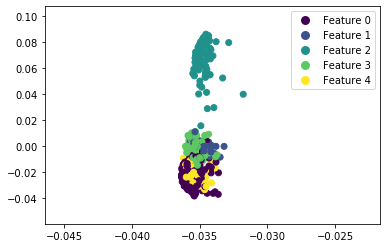

In [263]:
# coord 1 vs coord 2
plt.figure()
size=81
sc = plt.scatter(us[:,0], us[:,1], c=Xlabel)
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                        label="Feature {:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(Xlabel)]
plt.legend(handles=handles)
plt.show()

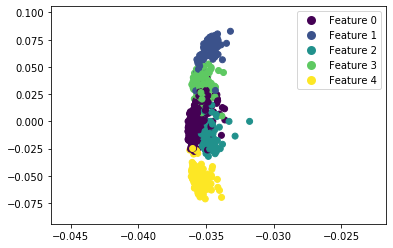

In [264]:
# coord 1 vs coord 3
plt.figure() 
size=81
sc = plt.scatter(us[:,0], us[:,2], c=Xlabel)
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                        label="Feature {:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(Xlabel)]
plt.legend(handles=handles)
plt.show()

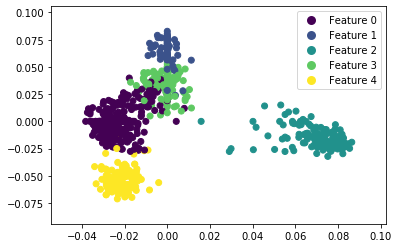

In [265]:
# coord 2 vs coord 3
plt.figure() 
size=81
sc = plt.scatter(us[:,1], us[:,2], c=Xlabel)
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                        label="Feature {:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(Xlabel)]
plt.legend(handles=handles)
plt.show()

Heatmap / layer plot:

In [6]:
def clusterheatmap(us, ss, vs, label):
    """Plot the clustered heatmap"""
    X_sparse = ss*us@vs.T
    levels = np.unique(label)
    row_index = np.empty(0, dtype = 'int')
    
    for i in range(len(levels)):
        index, = np.where(label == levels[i])
        index_sort = index[np.argsort(us.reshape(-1)[index])]
        row_index = np.concatenate((row_index, index_sort))
        
    v_reshape = vs.reshape(-1)
    col_sort = np.argsort(np.abs(v_reshape))
    X_sparse_sort = X_sparse[:,col_sort]
    col_index = np.argsort(v_reshape[col_sort])
    
    trans = (row_index.reshape(-1,1),col_index.reshape(1,-1))
    plot = sns.heatmap(X_sparse_sort[trans], vmin=-1, vmax=1, cmap = 'bwr')
    return plot

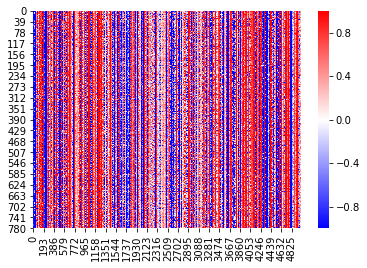

In [245]:
# Heatmap of original dataset
sns.heatmap(X, vmin=-1, vmax=1, cmap = 'bwr')
pass

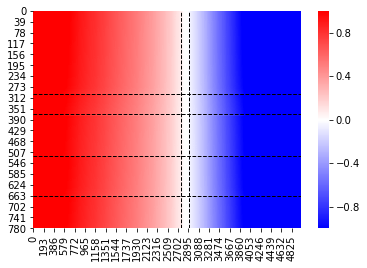

In [285]:
# First layer
clusterheatmap(us[:,0].reshape(-1,1),ss[0],vs[:,0].reshape(-1,1), Xlabel)
plt.axvline(x=2750,linestyle='--',c = 'k',linewidth = 1)
plt.axvline(x=2900,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(300,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(370,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(520,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(663,linestyle='--',c = 'k',linewidth = 1)
pass

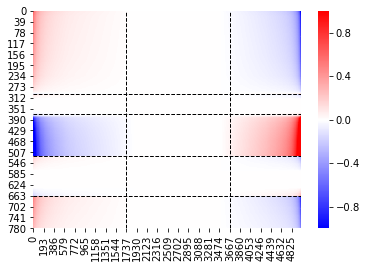

In [282]:
# Second layer
clusterheatmap(us[:,1].reshape(-1,1),ss[1],vs[:,1].reshape(-1,1),Xlabel)
plt.axvline(x=1737,linestyle='--',c = 'k',linewidth = 1)
plt.axvline(x=3667,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(300,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(370,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(520,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(663,linestyle='--',c = 'k',linewidth = 1)
pass

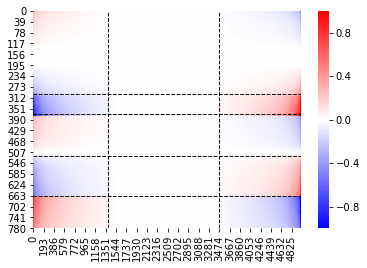

In [284]:
# Third layer
clusterheatmap(us[:,2].reshape(-1,1),ss[2],vs[:,2].reshape(-1,1),Xlabel)
plt.axvline(x=1400,linestyle='--',c = 'k',linewidth = 1)
plt.axvline(x=3474,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(300,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(370,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(520,linestyle='--',c = 'k',linewidth = 1)
plt.axhline(663,linestyle='--',c = 'k',linewidth = 1)
pass